In [3]:
import numpy as np
import pandas as pd
import opt_tugba
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import cvxpy
import analysis

import optimizer 
from datetime import datetime 
import json 
import warnings
warnings.filterwarnings("ignore")

## This is the function that will run in every 30 minutes 
z0 = np.array([25,35,1,1]).reshape(4,1) 

mean_duration_energy = pd.read_csv("mean_duration_energy.csv")
mean_duration_energy = mean_duration_energy.drop(columns="Unnamed: 0").set_index("arrHour")


interval_size_hour = 0.25
interval_size_minutes = int(60*interval_size_hour)
steps_in_hr = 4

################## Define the TOU Cost ##################
# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

# ################## Define the TOU Cost ##################
# # off-peak 0.175  cents / kwh 
# TOU_tariff = np.ones((144,)) * 17.5
# ## 4 pm - 9 pm peak 0.367 cents / kwh 
# TOU_tariff[96:126] = 36.7
# ## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
# TOU_tariff[54:84] = 14.9

results = pd.DataFrame(columns = ['arrHour', 'reg_centsPerHr','sch_centsPerHr','sch_overstayPerHr', 'sch_centsPerkWh', 'highPower', 'estDurationHrs','estEnergykWh'])
power_sch = pd.DataFrame(columns = ['arrHour', 'highPower', 'power_kw','estDurationHrs','estEnergykWh'])




In [2]:
df, results, power = analysis.optimize_low_pow_for_expected_params(8, mean_duration_energy, results, power_sch, TOU_tariff, z0=z0, plot = True)

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/interface/numpy_interface/ndarray_interface.py:47: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if result.d

ValueError: [ ERROR] invalid $v$

In [ ]:
TOU_tariff   * 3.3

In [ ]:
%%time
np.random.seed(1)
# Low Power
df_list = []
for arrival_hour in range(0,24):
    z0s= np.random.uniform(low=15, high=50, size=(10,))
    z1s = np.random.uniform(low=15, high=50, size=(10,))
    df_test = pd.DataFrame(index = range(len(z0s)), 
                         columns = ["hour","z0","z1","tariff_flex (cents/hour)","tariff_asap (cents/hour)","J","prob_asap","prob_flex","prob_leave"])
    row = 0 
    for z0_0, z1_0 in zip(z0s,z1s):
        z0 = np.array([z0_0,z1_0,1,1]).reshape(4,1)
        try:
            df, results, power = analysis.optimize_low_pow_for_expected_params(arrival_hour, mean_duration_energy, results, power_sch, TOU_tariff, z0 = z0, plot = False,data=True)
            df.reset_index(drop=False,inplace=True)
            df_test.loc[row, "hour"] = arrival_hour
            df_test.loc[row, "z0"] = z0_0
            df_test.loc[row, "z1"] = z1_0
            df_test.loc[row, "tariff_flex (cents/hour)"] = df.loc[0, "tariff_flex (cents/hour)"] 
            df_test.loc[row, "tariff_asap (cents/hour)"] = df.loc[0, "tariff_asap (cents/hour)"] 
            df_test.loc[row, "J"] = df.loc[0, "res"] 
            df_test.loc[row, "prob_asap"] = df.loc[0, "prob_asap"] 
            df_test.loc[row, "prob_flex"] = df.loc[0, "prob_flex"] 
            df_test.loc[row, "prob_leave"] = df.loc[0, "prob_leave"] 
        except: 
            df_test.loc[row, "z0"] = z0_0
            df_test.loc[row, "z1"] = z1_0
        row += 1
    df_test['delta_tariff (flex-asap)'] = df_test['tariff_flex (cents/hour)'] - df_test['tariff_asap (cents/hour)'] 
    df_test['delta_z0 (flex-asap)'] = df_test['z0'] - df_test['z1'] 
    df_list.append(df_test)

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


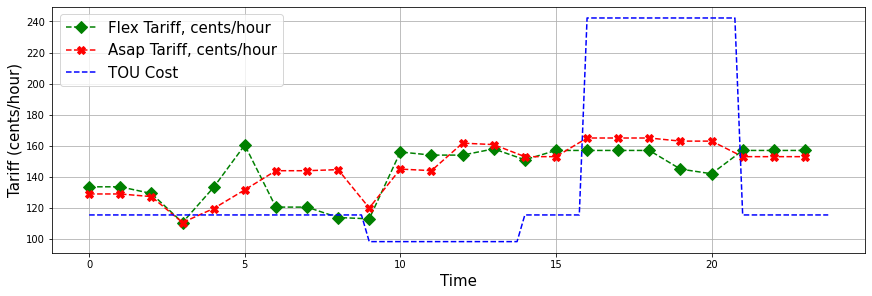

In [81]:
df = pd.concat(df_list)
df  = df.dropna()
df['mean_tariff'] = (df['tariff_asap (cents/hour)'] + df['tariff_flex (cents/hour)']) / 2

sch_low_prices = np.array([133.6 , 
                           133.6, 
                           129.3, 
                           129.3, 
                           133.25,
                           160.46, 
                           120.55, #6
                           120.55, # 7 
                           113.85, #8 
                           113, #9
                           156, #10
                           154,#11 
                           154, #12
                           158, #13
                           151, #14 
                           157, #15
                           157, #16
                           157, #17
                           157, #18
                           145, #19
                           142, #20
                           157, #21
                           157, #22
                           157, #23

                          ])

asap_low_prices = np.array([129 , 
                            129,
                            127.3, 
                            110.6, 
                            119.64, 
                            131.64, 
                            143.96, #6 
                            143.96, #7
                            144.65, # 8
                            120, # 9
                            145,#10
                            144, #11 ,
                            161.7, #12 
                            160.76, #13
                            153 ,#14
                            153 , #15
                            165 , #16
                            165 , #17
                            165 , #18
                            163 , #19
                            163 , #20
                            153 , #21
                            153 , #22  
                             153 , #23
                           ])
import matplotlib.pyplot as plt
## Plot initial guess vs optimization result 
fig,ax= plt.subplots(1,1,figsize=(12,4))
# Objective Value for each iteration 

arrHour = range(0,24)


ax.plot(arrHour, sch_low_prices, label = 'Flex Tariff, cents/hour', color = 'green', ms = 8, marker = 'D',linestyle = "--",)
ax.plot(arrHour, asap_low_prices, label = 'Asap Tariff, cents/hour', color = 'red', ms=8,marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), TOU_tariff * 6.6, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")



# ax.margins(0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Tariff (cents/hour)")
# ax.set_title("Objective Value")
ax.legend()

In [42]:
df[(df['J'] <=-50) & (df['tariff_asap (cents/hour)'] >= df['tariff_flex (cents/hour)']-20) ].sort_values(['hour','J']).reset_index(drop=True).iloc[20:]


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hour,z0,z1,tariff_flex (cents/hour),tariff_asap (cents/hour),J,prob_asap,prob_flex,prob_leave,delta_tariff (flex-asap),delta_z0 (flex-asap),mean_tariff
20,6,34.3488,43.2487,120.55,143.96,-74.12,0.37,0.4,0.23,-23.41,-8.89991,132.255
21,7,17.0971,34.8835,121.81,144.65,-169.06,0.37,0.4,0.23,-22.84,-17.7864,133.23
22,7,19.7759,48.8547,69.23,163.67,-98.38,0.16,0.66,0.18,-94.44,-29.0787,116.45
23,7,16.5593,23.8314,84.73,92.77,-78.12,0.44,0.37,0.19,-8.04,-7.27209,88.75
24,7,18.7623,41.0339,66.12,138.13,-74.4,0.22,0.59,0.18,-72.01,-22.2716,102.125
25,8,17.4508,38.4232,125.08,152.44,-171,0.35,0.42,0.23,-27.36,-20.9724,138.76
26,8,32.2819,49.6016,118.85,164.74,-168.68,0.29,0.48,0.23,-45.89,-17.3196,141.795
27,8,36.6985,35.2911,120.97,116.5,-135.18,0.48,0.31,0.21,4.47,1.40737,118.735
28,8,34.9098,27.9529,115.62,102.83,-115.27,0.51,0.29,0.2,12.79,6.95685,109.225
29,8,32.0221,24.2722,107.33,90.86,-93.42,0.53,0.28,0.19,16.47,7.74989,99.095


In [5]:
h=sns.jointplot(data=df_test,  
x='delta_z0 (flex-asap)', 
y='delta_tariff (flex-asap)')

# JointGrid has a convenience function
h.set_axis_labels("$\Delta z_0$\n(Flex - ASAP)", "$\Delta$Tariff\n(Flex - ASAP)", fontsize=16)


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-5-2c6b190a8e1b>:6: DeprecationWarning: invalid escape sequence \D
  h.set_axis_labels("$\Delta z_0$\n(Flex - ASAP)", "$\Delta$Tariff\n(Flex - ASAP)", fontsize=16)
<ipython-input-5-2c6b190a8e1b>:6: DeprecationWarning: invalid escape sequence \D
  h.set_axis_labels("$\Delta z_0$\n(Flex - ASAP)", "$\Delta$Tariff\n(Flex - ASAP)", fontsize=16)


NameError: name 'sns' is not defined

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, '\n J')

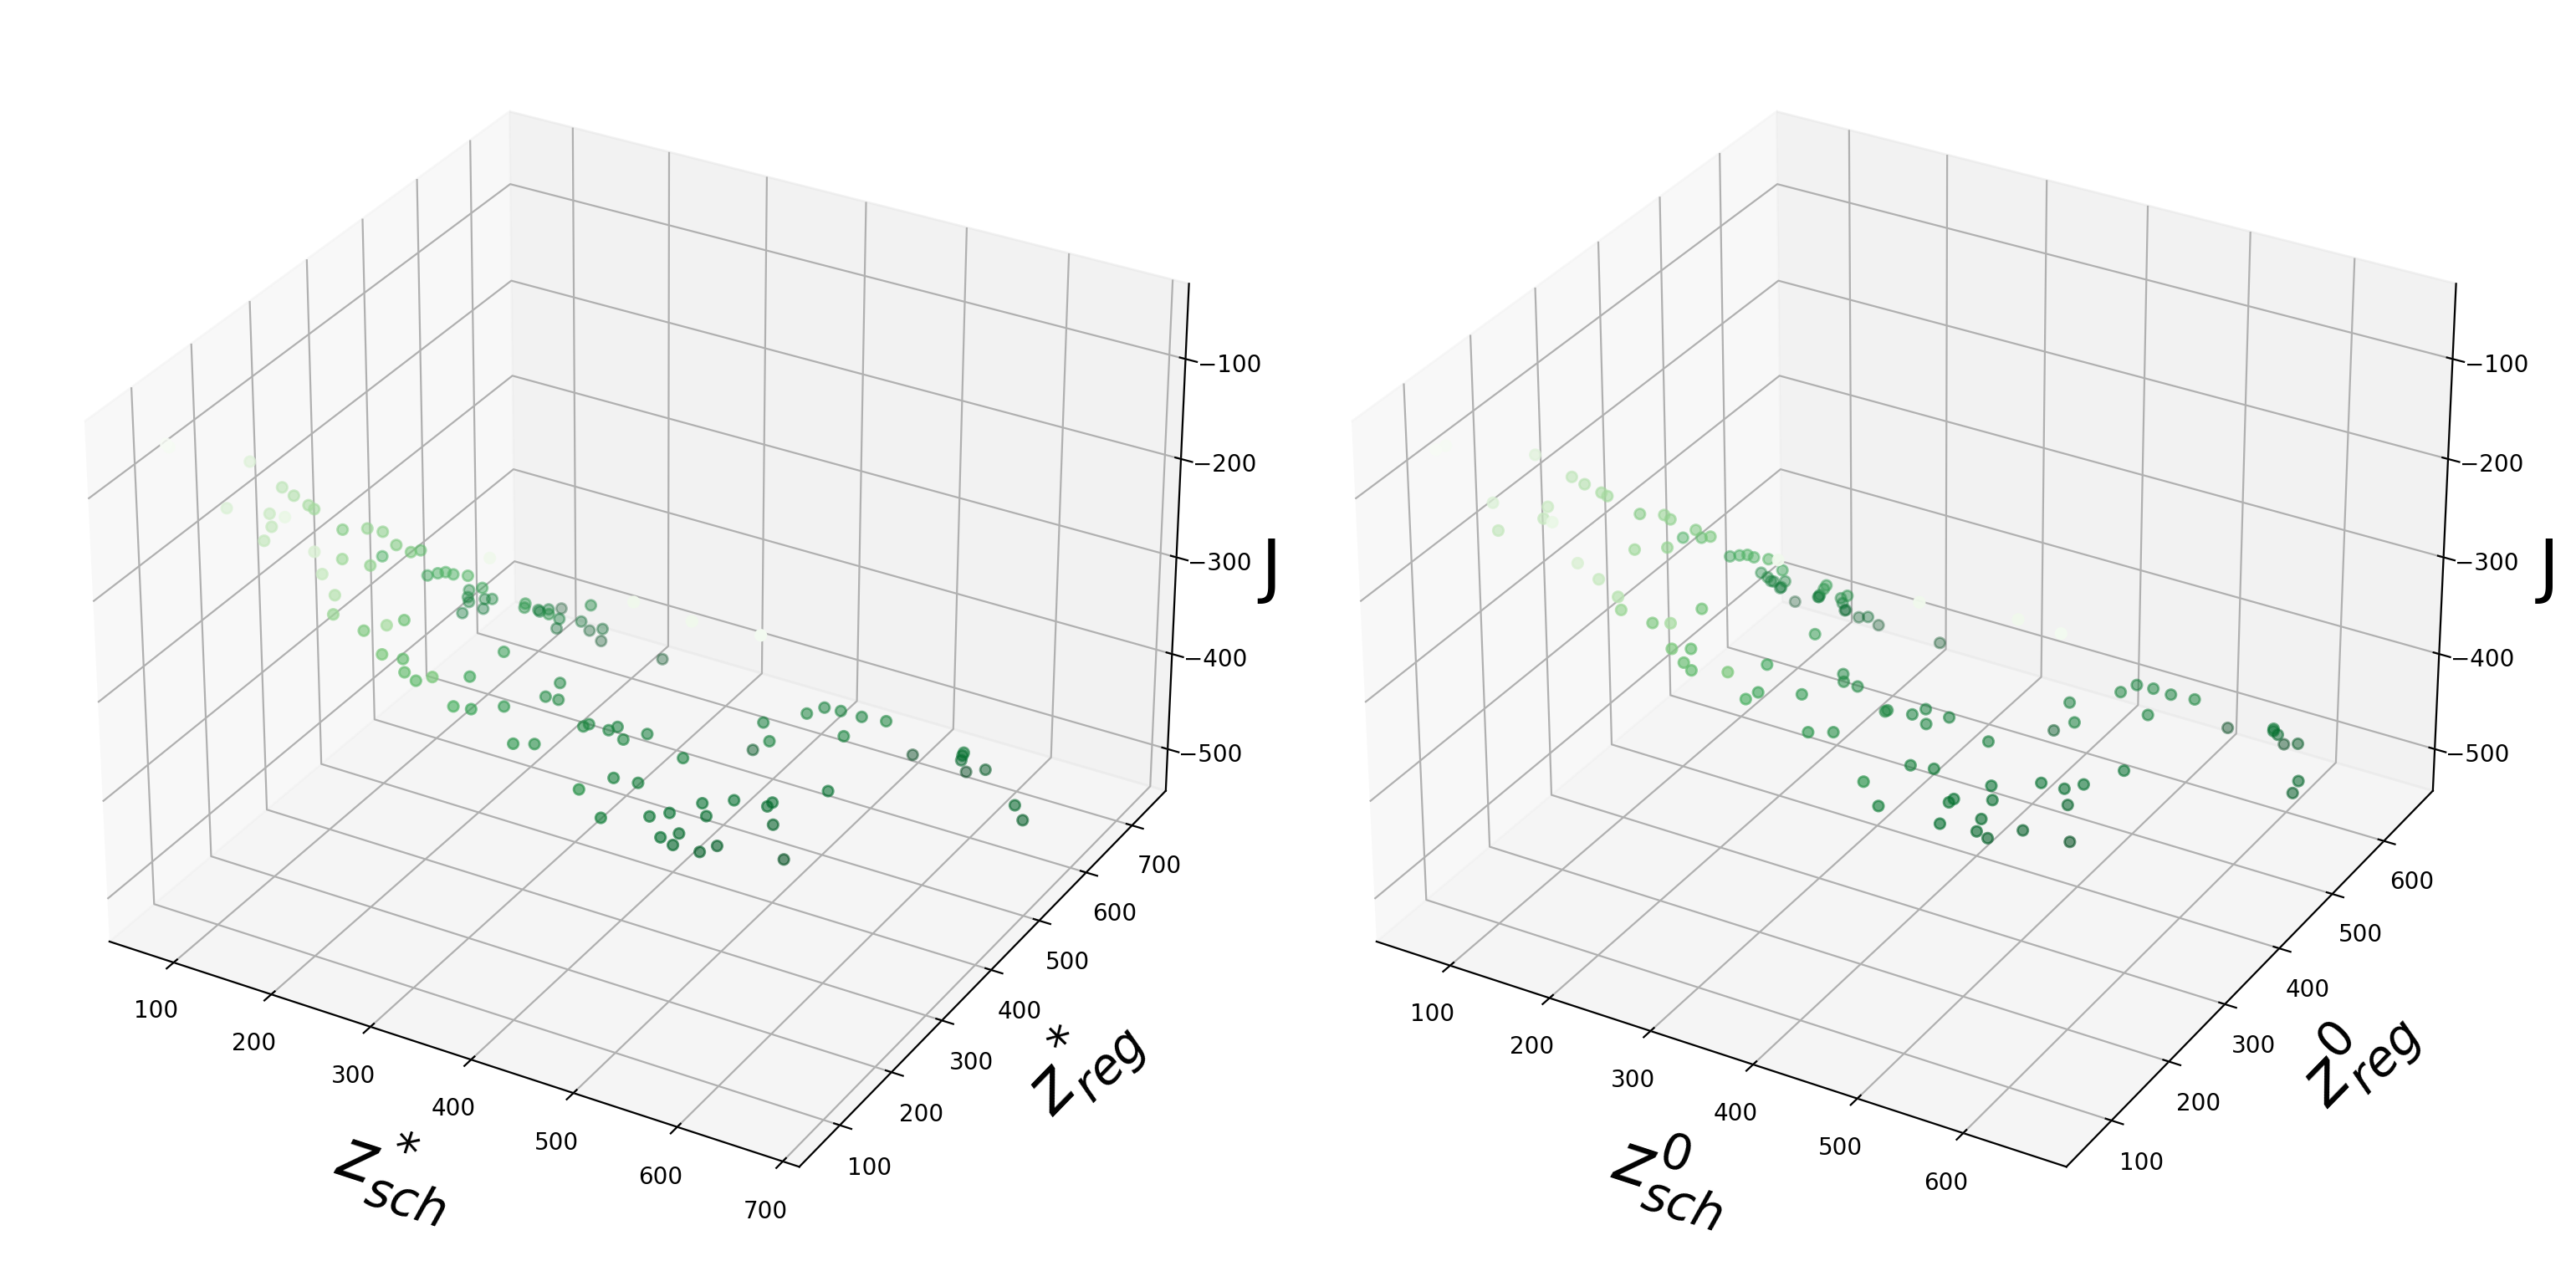

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, axes = plt.subplots(1,2,subplot_kw={"projection": "3d"}, figsize=(15,18), constrained_layout=True, dpi=200)
ax=axes[0]
# Make data.
X = df_test['tariff_flex (cents/hour)'].dropna().values
Y = df_test['tariff_asap (cents/hour)'].dropna().values
# X, Y = np.meshgrid(X, Y)
Z = df_test['J'].dropna().values
fig = plt.figure()
p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')
ax.set_xlabel('\n$z^*_{sch}$',size=30)
ax.set_ylabel('\n$z^*_{reg}$',size=30)
ax.set_zlabel('\nJ',size=30)
# ax.set_xlim(1,500)
# ax.set_ylim(1,500)
ax=axes[1]
X = df_test.dropna()['z0'].values * 3.3
Y = df_test.dropna()['z1'].values * 3.3
# X, Y = np.meshgrid(X, Y)
Z = df_test.dropna()['J'].values
fig = plt.figure()
p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')

# ax.plot3D(X, Y, Z, 'gray')
ax.set_xlabel('\n $z^0_{sch}$',size=30)
ax.set_ylabel('\n $z^0_{reg}$',size=30)
ax.set_zlabel('\n J',size=30)


In [32]:
df_test.dropna()

,hour,z0,z1,tariff_flex (cents/hour),tariff_asap (cents/hour),J,prob_asap,prob_flex,prob_leave,delta_tariff (flex-asap),delta_z0 (flex-asap)
1,8,149.658,120.198,509.78,402.73,-497.52,0.49,0.05,0.46,107.05,29.4608
4,8,46.4161,90.2014,157.94,285.6,-247.52,0.09,0.68,0.23,-127.66,-43.7853
5,8,36.6209,107.478,126.98,362.29,-256.75,0.02,0.86,0.12,-235.31,-70.8574
6,8,53.5268,128.776,177.22,427.11,-316.47,0.01,0.85,0.14,-249.89,-75.249
7,8,82.2009,118.919,273.22,395.62,-398.29,0.09,0.56,0.35,-122.4,-36.7177
...,...,...,...,...,...,...,...,...,...,...,...
191,8,31.873,163.749,108,549.54,-414.54,0,0.97,0.03,-441.54,-131.876
193,8,158.992,24.9691,528.21,81.3,-82.94,0.98,0,0.02,446.91,134.023
196,8,22.5113,88.5829,76.81,292.92,-203.76,0.02,0.87,0.11,-216.11,-66.0716
197,8,62.1852,154.974,209,520.93,-389.94,0,0.88,0.11,-311.93,-92.7893


In [37]:
df_test=df_test[~df_test['hour'].isnull()]

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, '\n J')

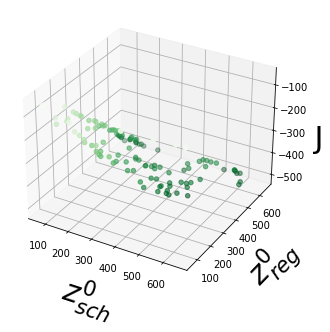

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = df_test.dropna()['z0'].values * 3.3
Y = df_test.dropna()['z1'].values * 3.3
# X, Y = np.meshgrid(X, Y)
Z = df_test.dropna()['J'].values
fig = plt.figure()
p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')

# ax.plot3D(X, Y, Z, 'gray')
ax.set_xlabel('\n $z^0_{sch}$',size=30)
ax.set_ylabel('\n $z^0_{reg}$',size=30)
ax.set_zlabel('\n J',size=30)
# ax.set_xlim(10,50)
# ax.set_ylim(10,50)


In [134]:
df_test.sort_values("J",inplace=True)
df_test

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hour,z0,z1,tariff_flex (cents/hour),tariff_asap (cents/hour),J,prob_asap,prob_flex,prob_leave,delta_tariff (flex-asap),delta_z0 (flex-asap)
53,21,20.6219,48.9513,169.99,184.41,-115.07,0.39,0.36,0.25,-14.42,-28.3295
74,21,25.9071,48.9521,166,174.27,-109.54,0.41,0.34,0.25,-8.27,-23.045
0,21,26.6809,48.007,169.36,168.01,-108.14,0.45,0.31,0.24,1.35,-21.3262
156,21,17.8172,41.8635,160.54,167.97,-104.6,0.42,0.34,0.24,-7.43,-24.0464
8,21,25.8707,47.0473,160.37,167.74,-104.43,0.42,0.34,0.24,-7.37,-21.1766
...,...,...,...,...,...,...,...,...,...,...,...
160,21,19.5939,22.0099,77.08,77.26,-20.89,0.49,0.35,0.17,-0.18,-2.41602
153,21,18.1317,20.2828,75.86,75.07,-18.97,0.49,0.35,0.17,0.79,-2.15104
190,21,20.5319,18.4784,73.43,72.52,-16.37,0.49,0.35,0.16,0.91,2.05346
84,21,20.7971,20.0947,68.09,67.57,-10.96,0.49,0.35,0.16,0.52,0.702448


In [23]:
%%time
np.random.seed(1)
# Low Power
df2_list = []
for arrival_hour in range(0,24):
    z0s= np.random.uniform(low=15, high=50, size=(10,))
    z1s = np.random.uniform(low=15, high=50, size=(10,))
    df2_test = pd.DataFrame(index = range(len(z0s)), 
                         columns = ["hour","z0","z1","tariff_flex (cents/hour)","tariff_asap (cents/hour)","J","prob_asap","prob_flex","prob_leave"])
    row = 0 
    for z0_0, z1_0 in zip(z0s,z1s):
        z0 = np.array([z0_0,z1_0,1,1]).reshape(4,1)
        try:
            df2, results, power = analysis.optimize_high_pow_for_expected_params(arrival_hour, mean_duration_energy, results, power_sch, TOU_tariff, z0 = z0, plot = False,data=True)
            df2.reset_index(drop=False,inplace=True)
            df2_test.loc[row, "hour"] = arrival_hour
            df2_test.loc[row, "z0"] = z0_0
            df2_test.loc[row, "z1"] = z1_0
            df2_test.loc[row, "tariff_flex (cents/hour)"] = df2.loc[0, "tariff_flex (cents/hour)"] 
            df2_test.loc[row, "tariff_asap (cents/hour)"] = df2.loc[0, "tariff_asap (cents/hour)"] 
            df2_test.loc[row, "J"] = df2.loc[0, "res"] 
            df2_test.loc[row, "prob_asap"] = df2.loc[0, "prob_asap"] 
            df2_test.loc[row, "prob_flex"] = df2.loc[0, "prob_flex"] 
            df2_test.loc[row, "prob_leave"] = df2.loc[0, "prob_leave"] 
        except: 
            df2_test.loc[row, "z0"] = z0_0
            df2_test.loc[row, "z1"] = z1_0
        row += 1
    df2_test['delta_tariff (flex-asap)'] = df2_test['tariff_flex (cents/hour)'] - df2_test['tariff_asap (cents/hour)'] 
    df2_test['delta_z0 (flex-asap)'] = df2_test['z0'] - df2_test['z1'] 
    df2_list.append(df2_test)

/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

13 -0.12111022377732183


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

3 -0.2597312786593591
1 -7.799969566104501
1 -16.558634264729065


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

12 -0.06560790680757833
1 -49.268562145894066


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

19 -0.051725503904123116


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

15 -0.6438137923028222


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

10 -0.12403173498164222
2 -7.632422356847428
3 -0.34303835951106976


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -25.597362155727893
3 -0.22775752296698215
2 -0.012209932904198695
73 -3.590052504722351
1 -54.49827941706378
1 -96.72236229397801


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

35 -0.8107790333969973


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

160 -0.45012928390030993


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

19 -0.3262936703998207


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

4 -0.6372630328186517
16 -3.662027175468026
1 -16.099918126485527


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

2 -2.4582070750511775e-05
11 -0.2636696219371686


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

30 -0.6817248231410957
1 -41.7177929438909
1 -86.21107042093931


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

25 -1.0966805007034282
3 -2.614484763326658


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -1.626340577659704
1 -17.95793299282664


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

34 -1.420068772440061


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

12 -1.194629009325837


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

7 -0.42675485702844185


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

11 -1.0476237573055016


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

72 -4.087857991177231
3 -2.0606637594744655


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

29 -2.419711392417554


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

21 -0.8482056638527666
2 -0.07839130491930746


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

7 -7.8753456190633955


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

5 -2.1281619850886386


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

11 -3.5413543501164213
1 -6.159019842330915


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

19 -0.19722538147291857


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

26 -0.757932795648415


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

20 -1.469530364371522


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

89 -0.4695510493566246
3 -0.8057851264392468


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

13 -1.4010277838295906
1 -90.77568894000777


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

7 -0.4769285611016585


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -0.2355238896709011
1 -53.77331482720127


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

1 -118.24918432238788
1 -52.26244639026282


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

2 -1.3892822463034236
15 -0.11575380193124829
4 -0.11137717459807561


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -68.3313427150393
1 -2.928645300268741


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

3 -0.5628617311230073
1 -157.13982028676443
1 -62.704323632339424


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

4 -0.6392629226887152


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

31 -1.034023026528871
1 -105.11559505601593


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

6 -1.356143117805118
2 -3.537659121042452


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -211.84378145027148
17 -1.4892627892234032
2 -5.867311161325972


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

195 -0.6000943361609643


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

28 -7.2537120705977145


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

21 -1.0889001974852022
1 -153.56662783005305


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -81.92771910231897
2 -2.325706138533633


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

7 -5.432435584552408


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

5 -0.021867227051984628


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

32 -5.278431093292852


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

11 -0.2160834149716777


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

80 -3.346613289578954
1 -147.57113418839577


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -49.19721449016359
221 -4.537884376154466


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

25 -1.329781251560462


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

41 -4.9454545030378085


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

9 -2.890336931574325


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

46 -1.3101130957276155


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

39 -16.57371399214469


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

57 -5.235986165676309


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

18 -8.112902390177652


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

7 -0.9643494538771051


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

18 -0.4662116899950206


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

3 -4.71313107389912
2 -7.308216446657752


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

52 -1.4063088363590168


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

15 -0.13367133329580838


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

11 -1.0377495208621212
1 -71.90321111980364


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

5 -7.6872044511347895


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

11 -1.0789085207216544
3 -0.7094175244776011


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

33 -4.554317808550536
2 -3.8632308927897725


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

73 -4.9758349762297485


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

66 -3.668494457424117


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

21 -0.7460110220456215
2 -1.8129562371447037


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

6 -2.0248673196986715
1 -74.18711338640829
3 -0.49241022933856016


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

71 -0.35574685121207494
1 -44.35415109568417


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

20 -0.03426494809551173


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

23 -3.459476575580368
2 -2.8551814979229277


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

4 -0.30885851876243464


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -7.656922235248089
3 -0.41980463963821535


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

18 -0.2176526065373423
2 -2.067566886710665


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

8 -1.503709939684171
3 -3.825754760513803


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

16 -0.15195527077662518
2 -0.17802074639715215


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

2 -2.5334062873661196
2 -0.036046098139820515


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

80 -0.43368303034250744
3 -0.29698411493177446


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

19 -0.5862393903806549


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -0.5042742435626479


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

19 -9.461760508518942
3 -0.033312834691756166


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

24 -1.970927108725732


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

28 -3.5018068485230742
2 -1.2765100760919097


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

34 -0.32561321245475483
1 -0.8696925479335533
1 -35.908559237897535


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -28.432582378138804
2 -0.7723238716584575
1 -15.996956075334438


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

27 -1.3351992935014465
1 -80.00581743729875
1 -74.32955529971034


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

12 -0.9280821076589092
1 -67.3920862984059
1 -149.97621331327414


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -28.99378726104078
1 -116.34829071702191
1 -89.42877398346343


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

1 -12.190069386439717
1 -32.731487676675265


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

23 -0.013346278745295592


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -1.1424593709876802
2 -1.0016461277313837
1 -37.34913785474124


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -38.89747311487875
1 -113.72077153125971
1 -13.642584729220417


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

2 -0.3336638873686759
1 -1.3983656524885824
11 -0.09352408989261107
1 -197.630903628186
1 -39.50300569450072


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -96.02887617607949
1 -85.1661371070787
1 -13.271450103934995


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

1 -112.29025426981991
1 -16.280144911998498


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -0.15991851646960242
1 -6.388257033920457
1 -10.220215877657308


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

1 -77.19790748231738
1 -19.615739358014565
2 4.46789272245951e-11


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -30.61518338706979
1 -64.89156161108986
1 -20.818285616567437


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` f

1 -67.09696367351135


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

5 -1.3078273867573955
1 -83.87931502475075


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

23 -1.0275904702974685
1 -38.446923758612236


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

12 -0.1136274559143331
1 -76.3175563636001
4

/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

 -0.08781821758212516
1 -2.9141148515041193
1 -13.970838360856877
1 -43.27330479198902


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

1 -7.596174408039564
1 -68.23668281438287


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


10 -0.5112942172465651


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

25 -0.2372505282701809
1 -22.32761149481488
1 -52.435032224396174


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -31.48934890052471
2 -2.0966350109398206
1 -1.342994270172973
1 -144.8570086776343


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

19 -9.854037562878915


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

10 -1.5405699450936652


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

6 -6.566139304808928


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

13 -2.381169713960716
1 -88.92853938808418
2 -0.22456025578685512


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

1 -174.7309762516583


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


36 -0.6182482738724389
2 -0.5668951180811064


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

2 -1.7086598127445995


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


37 -5.3838327589205335


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

30 -0.8537153733363851
2 -0.6914696269139355
1 -104.88091449824614


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

21 -0.0826738332704906


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

38 -0.6271230019129064


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

12 -0.39112057634696384


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

217 -2.476713101325231


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

21 -0.6963811873590942
2 -0.010175794773147118
1 -37.82512403130811


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

8 -0.45110449925464735


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:423: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

12 -0.7227349118733741
CPU times: user 2min 46s, sys: 3.11 s, total: 2min 49s
Wall time: 2min 48s


In [4]:
df2 = pd.concat(df2_list)
df2  = df2.dropna()
df2['mean_tariff'] = (df2['tariff_asap (cents/hour)'] + df2['tariff_flex (cents/hour)']) / 2

sch_low_prices = np.array([230,  #0
                           230,  #1
                           246,  #2
                           246,  #3
                           246, #4
                          198,  #5
                           220, #6
                           217, # 7 
                           217, #8 
                           237, #9
                           215, #10
                           215, #11
                           233, #12
                           238, #13
                           246, #14 
                            246, #15
                           265, #16
                           264, #17
                           255, #18
                           233, #19
                           206, #20
                           228, #21
                            228, #22
                            228, #23

                          ])

asap_low_prices = np.array([221 , #0
                            221 , #1 
                            242 , #2
                            242, #3
                            242, #4
                            253, #5
                            273, #6 
                            277, #7
                            275, # 8
                            217, # 9
                            217, # 10
                            217, # 11
                            217, # 12
                            217, #13
                            242 ,#14
                            242 , #15
                            260 , #16
                            260 , #17
                            266 , #18
                            283 , #19
                            270.38 , #20
                            215 , #21
                           215 , #22  
                            215 , #23
                           ])
df2[(df2['J'] <=-50) & (df2['tariff_asap (cents/hour)'] >= df2['tariff_flex (cents/hour)']-20)  
    & (df2['prob_leave'] < 1)].sort_values(['hour','J']).reset_index(drop=True).iloc[70:]
import matplotlib.pyplot as plt
## Plot initial guess vs optimization result 
fig,ax= plt.subplots(1,1,figsize=(12,4))
# Objective Value for each iteration 

arrHour = range(0,24)


ax.plot(arrHour, sch_low_prices, label = 'Flex Tariff, cents/hour', color = 'green', ms = 8, marker = 'D',linestyle = "--",)
ax.plot(arrHour, asap_low_prices, label = 'Asap Tariff, cents/hour', color = 'red', ms=8,marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), TOU_tariff * 6.6, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")



# ax.margins(0)
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Tariff (cents/hour)")
# ax.set_title("Objective Value")
ax.legend()

NameError: name 'df2' is not defined

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='delta_tariff (flex-asap)', ylabel='Count'>

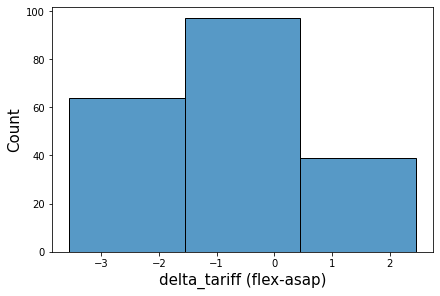

In [29]:
sns.histplot(data=df_test, x='delta_tariff (flex-asap)', binwidth = 2)


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='z0', ylabel='delta_tariff (flex-asap)'>

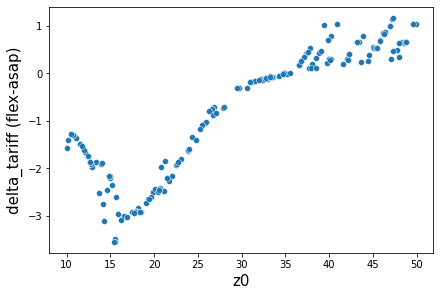

In [34]:
sns.scatterplot(data=df_test, x='z0', y='delta_tariff (flex-asap)')

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='z0', ylabel='J'>

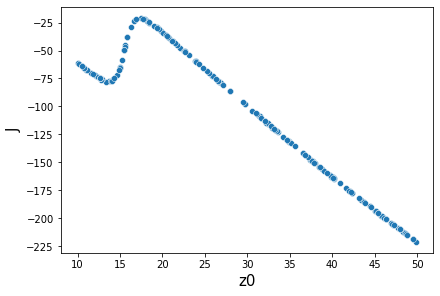

In [35]:
sns.scatterplot(data=df_test, x='z0', y='J')

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='z0', ylabel='prob_flex'>

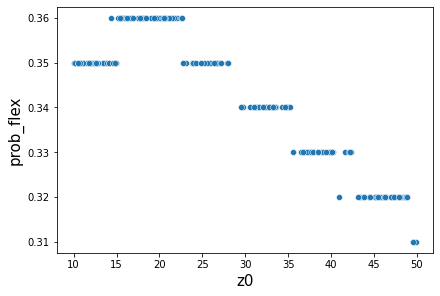

In [37]:
sns.scatterplot(data=df_test, x='z0', y='prob_flex')

In [136]:
for arrival_hour in range(0,24):
    results, power_sch = analysis.optimize_high_pow_for_expected_params(arrival_hour, mean_duration_energy, results, power_sch, TOU_tariff, z0=z0, plot = False)
    z0 = np.array([20,40,1,1]).reshape(4,1) 
    results, power_sch = analysis.optimize_low_pow_for_expected_params(arrival_hour, mean_duration_energy, results, power_sch, TOU_tariff,z0=z0, plot = False)
results.to_csv("Outputs/Prices_steps15_4.csv")
power_sch.to_csv("Outputs/Powers_steps15_4.csv")

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multipli

1 -29.539339379835724
55 -3.764821973106791e-05
1 -29.539339379835724


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -3.764821973106791e-05
1 -29.539339379835724


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -3.764821973106791e-05
1 -29.539339379835724


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -3.764821973106791e-05
1 -29.539339379835724


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -3.764821973106791e-05
1 -29.539339379835724


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -3.764821973106791e-05
1 -28.163856486106027


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.04955190543292076
1 -36.829526494631466


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

34 -0.10370865836702592
1 -36.02629020211418


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

39 -0.1366906945004871
1 -41.85970743377584


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.12151290870701814
1 -67.39103574286148


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060:

38 -0.10458448641463747
1 -28.350822385084427


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.07691437331277484
1 -24.726420521651747


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.059190126743715155
1 -39.04044112823317


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

59 -0.004351615063541203
1 -30.72829487544


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

55 -0.0008119561054229507
1 -90.43504514733182


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

31 -0.06926800454644422
1 -133.62201043319297
1 -12.446544353986122
1

/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

 -83.35107458386865
1 -13.872231165728088
1 -115.89896715453156
1 -20.258953647169378


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

1 -53.921857143136705
1 -1.6020488500091972
1 -27.635763480102206


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

23 -0.031116009780653542
1 -38.03844303005367


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.04950768433803887
1 -38.03844303005367


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.04950768433803887
1 -38.03844303005367


/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Python Code/optimizer.py:401: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return  np.array([J_1 , J_2 , J_3])
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/Documents/eCal/SlrpEV/pev-operation-hil/pev-operation-hil/scripts/Pyth

38 -0.04950768433803887


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/s3fs/mapping.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import MutableMapping


event

In [6]:
arrival_hour



/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


22

In [4]:
z_flex = res["tariff_flex"]
z_asap = res["tariff_asap"]
prob_flex = res['prob_flex']
prob_asap = res['prob_asap']
f_flex = np.multiply(res["flex_powers"], prb.TOU - z_flex) * par.Ts
f_asap = np.multiply(prb.station_pow_max , (prb.TOU[:prb.N_asap] - z_asap))* par.Ts
print(z_flex * 6.6), print(z_asap * 6.6)
(prob_flex * f_flex).sum()+(prob_asap * f_asap).sum()


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'res' is not defined

In [ ]:
prb.TOU, prb.N_asap, prb.N_flex,res["flex_powers"], res["asap_powers"]
z_flex = res["tariff_flex"]
z_asap = res["tariff_asap"]
prob_flex = res['prob_flex']
prob_asap = res['prob_asap']
prob_leave = res['prob_leave']
f_flex = np.multiply(res["flex_powers"], prb.TOU - z_flex) * par.Ts
f_asap = np.multiply(prb.station_pow_max , (prb.TOU[:prb.N_asap] - z_asap))* par.Ts

J = (prob_flex * f_flex).sum() +  (prob_asap * f_asap).sum()
print((prob_flex * f_flex).sum(),(prob_asap * f_asap).sum(), J)
print(z_asap * 6.6,z_flex * 6.6)
print(prob_asap, prob_flex, prob_leave,np.sum([prob_asap, prob_flex, prob_leave]))

res['J']



-5.280172854267498 -7.881156253608231 -13.16132910787573
81.59389840444841 87.50517793160473
0.5054 0.3241 0.1704 0.9998999999999999


array([ 10.989     , -10.02385946, -11.75141212, -12.47898897,
       -12.84482002, -12.96323627, -13.0488202 , -13.10856414,
       -13.15048407, -13.17869066, -13.19751057, -13.2117483 ,
       -13.22126512])

In [3]:
x1 = 363
x2 = 361

u_reg =  0.3411 -0.0184*(x1 - x2)*.5
u_sch = 0.0184*(x1 - x2)*.5
u_leave = -1. + 0.005*(np.mean([x1, x2]))

print(u_leave, u_sch, u_reg)
denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

p_reg = np.exp(u_reg) / denom
p_sch = np.exp(u_sch) / denom
p_leave = np.exp(u_leave) / denom

print(p_reg, p_sch, p_leave, np.sum([p_reg, p_sch, p_leave]))





0.81 0.0184 0.3227
0.2971278623667873 0.21917326013074737 0.4836988775024654 1.0


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def calculate_probability(z_reg, z_sch):
    u_reg =  0.3411 -0.0184*(z_reg - z_sch)*.5
    u_sch = 0.0184*(z_reg - z_sch)*.5
    u_leave = -1. + 0.005*(np.mean([z_sch, z_reg]))

    
    denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

    p_reg = np.exp(u_reg) / denom
    p_sch = np.exp(u_sch) / denom
    p_leave = np.exp(u_leave) / denom
    print(u_reg, u_sch, u_leave)
    return p_reg, p_sch, p_leave 

In [25]:
calculate_probability(300, 300)

0.3411 0.0 0.5


(0.34683582247398637, 0.24659604041816177, 0.40656813710785183)

In [16]:
prob_leave = []
prob_asap = []
prob_flex = []
x1s = []
x2s = []
for x1 in range(0,500):
    for x2 in range(0,500):
        u_reg =  0.3411 -0.0184*(x1 - x2)*.5
        u_sch = 0.0184*(x1 - x2)*.5
        u_leave = -1. + 0.005*(np.mean([x1, x2]))
        denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

        p_reg = np.exp(u_reg) / denom
        p_sch = np.exp(u_sch) / denom
        p_leave = np.exp(u_leave) / denom

        prob_leave.append(p_leave)
        prob_asap.append(p_reg)
        prob_flex.append(p_sch)
        x1s.append(x1)
        x2s.append(x2)




data = pd.DataFrame(data = {"x1s":x1s, "x2s":x2s,"P_leave":prob_leave, "p_asap":prob_asap,"p_flex":prob_flex})
data["delta_x"] = (data["x1s"] - data["x2s"]).values 
data["mean_x"] = (data["x1s"] + data["x2s"]).values  / 2 


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
data[data["mean_x"] == 10]

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x1s,x2s,P_leave,p_asap,p_flex,delta_x,mean_x
20,0,20,0.132932,0.581111,0.285957,-20,10.0
519,1,19,0.133639,0.573547,0.292815,-18,10.0
1018,2,18,0.134313,0.565930,0.299757,-16,10.0
1517,3,17,0.134954,0.558265,0.306781,-14,10.0
2016,4,16,0.135561,0.550554,0.313885,-12,10.0
2515,5,15,0.136134,0.542801,0.321065,-10,10.0
3014,6,14,0.136672,0.535009,0.328319,-8,10.0
3513,7,13,0.137174,0.527183,0.335643,-6,10.0
4012,8,12,0.137639,0.519326,0.343035,-4,10.0
4511,9,11,0.138066,0.511442,0.350491,-2,10.0


In [18]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rcParams.update({'font.size': 25})

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


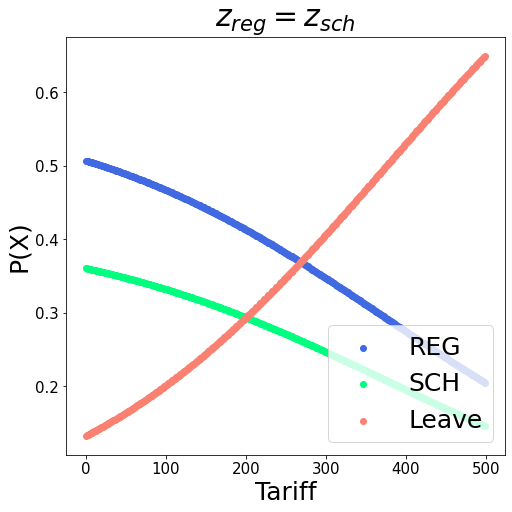

In [19]:
fig,(ax2) = plt.subplots(1,1,figsize=(7,7) ,)

# ax1.scatter(data["mean_x"], data['P_leave'], color = "salmon")
# ax1.set_xlabel("Mean($z_{reg},z_{sch}$)")
# ax1.set_title("$P_{Leave}$")


ax2.set_ylabel("P(X)")


tmp = data[data["x1s"] == data['x2s']]
ax2.scatter(tmp["x1s"], tmp['p_asap'], color="royalblue", label = "REG")
ax2.scatter(tmp["x2s"], tmp['p_flex'], color = "springgreen", label = "SCH")
ax2.scatter(tmp["x2s"], tmp['P_leave'], color = "salmon", label = "Leave")
ax2.set_xlabel("Tariff")
ax2.set_title("$z_{reg}=z_{sch}$")
ax2.legend(loc=4)

In [ ]:
import time
pathOfFile = ("Outputs")
fileStatsObj = os.stat(pathOfFile)
modificationTime = time.ctime ( fileStatsObj[ stat.ST_MTIME ] )
 
print("Last Modified Time : ", modificationTime )

NameError: name 'stat' is not defined

In [ ]:
modTimesinceEpoc = os.path.getmtime(pathOfFile)
(time.time() - modTimesinceEpoc ) < 30 
print("Current time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), "\nLast Modified: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(modTimesinceEpoc)))
# Convert seconds since epoch to readable timestamp

# modificationTime = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(modTimesinceEpoc))
print("Last Modified Time : ", modificationTime )

Current time:  2022-03-01 11:00:40 
Last Modified:  2022-02-28 21:01:24
Last Modified Time :  2022-02-28 21:01:24


time.struct_time(tm_year=2022, tm_mon=2, tm_mday=28, tm_hour=21, tm_min=1, tm_sec=24, tm_wday=0, tm_yday=59, tm_isdst=0)

13.963809626764721

In [ ]:
15 / 60 

In [ ]:
str(list(par.z0.reshape((4,))))

'[1, 1, 1, 1]'

In [ ]:
df_flex = pd.DataFrame(index =  np.arange(6,96,6), columns = np.arange(5,55,5))
df_asap = pd.DataFrame(index =  np.arange(6,96,6), columns = np.arange(5,55,5))

dict_keys(['z', 'tariff_flex', 'tariff_asap', 'tariff_overstay', 'peak_pow', 'flex_e_delivered', 'flex_powers', 'asap_powers', 'v', 'prob_flex', 'prob_asap', 'prob_leave', 'J', 'J_sub', 'z_iter', 'v_iter', 'rev_flex', 'rev_asap', 'num_iter', 'prb', 'par', 'time_start', 'time_end_flex', 'time_end_asap'])

In [ ]:
## Wgy scale dependent? 
res['tariff_flex']

21.015485386001675

In [ ]:
        ### Read parameters 
        N_flex = prb.N_flex
        N_asap = prb.N_asap
        TOU = prb.TOU
        station_pow_max = prb.station_pow_max
        lam_x = par.lam_x
        lam_h_c = par.lam_h_c
        lam_h_uc = par.lam_h_uc
        user_SOC_init  =  prb.user_SOC_init
        user_SOC_need = prb.user_SOC_need
        delta_k = par.Ts
        eff = par.eff
        user_bat_cap = prb.user_batt_cap  
        print("Lam_X:",lam_x)
        print(N_flex, N_asap, lam_x, user_SOC_init, user_SOC_need,eff)
        objective = "J = u.T @ TOU + norm2 * {} + lam_h_c * 1 / z[2] \n + cp.sum(station_pow_max * (TOU[:N_asap] - z[1])) \n v[2] * cp.sum(TOU[:N_asap])".format(lam_x)

AttributeError: 'Problem' object has no attribute 'user_SOC_init'

In [ ]:
def calculate_probs(x1,x2):
    u_reg =  0.3411 -0.0184*(x1 - x2)*.5
    u_sch = 0.0184*(x1 - x2)*.5
    u_leave = -1. + 0.005*(np.mean([x1, x2]))

    denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

    p_reg = np.exp(u_reg) / denom
    p_sch = np.exp(u_sch) / denom
    p_leave = np.exp(u_leave) / denom 
    print("Regular:",np.round(p_reg,3)," Scheduled:",np.round(p_sch,3),"Leave:",np.round(p_leave,3))


x1 = 150
x2 = 150

calculate_probs(x1,x2)


Regular: 0.442  Scheduled: 0.314 Leave: 0.244


In [ ]:
cvxpy.__version__

'1.1.7'

In [ ]:
import pandas as pd 
pd.__version__

'1.1.3'

In [ ]:
np.__version__


'1.19.1'

In [ ]:
import gurobi
gurobi?

Type:        module
String form: <module 'gurobi' from '/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/gurobi/__init__.py'>
File:        ~/miniconda3/lib/python3.8/site-packages/gurobi/__init__.py
Docstring:   <no docstring>
